In [1]:
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
import xarray as xr

# custom
from utils.loss import MS_SSIMLoss
from utils.custom_dataset import ClimateHackDataset

In [2]:
from fastai.vision.all import *

## Data

In [3]:
# # SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"
# SATELLITE_ZARR_PATH = 'data/eumetsat_seviri_hrv_uk.zarr/'

# dataset = xr.open_dataset(
#     SATELLITE_ZARR_PATH, 
#     engine="zarr",
#     chunks="auto",  # Load the data as a Dask array
# )

# print(dataset)

In [4]:
# arr = np.load('data/test.npz')

In [6]:
BATCH_SIZE = 64
train_ds = ClimateHackDataset("data/train.npz")
valid_ds = ClimateHackDataset("data/test.npz")

# train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
# valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, pin_memory=True)

# train_loader.n = len(train_ds.cached_items)
# valid_loader.n = len(valid_ds.cached_items)

dls = DataLoaders(train_loader, valid_loader)

In [8]:
next(iter(train_loader))[1].shape

torch.Size([64, 24, 128, 128])

## Training

In [6]:
FORECAST = 24
criterion = MS_SSIMLoss(channels=FORECAST)

In [7]:
class SmartShrink(nn.Module):
    def __init__(self, size=(64, 64)):
        super().__init__()
        self.size = size

    def forward(self, x):
        return F.interpolate(x, size=self.size)

model = create_unet_model(
    arch=models.resnet50, img_size=(128, 128), n_out=24, pretrained=True, n_in=14, self_attention=True, 
)
model.layers.add_module("SmartShrink", SmartShrink(size=(64, 64)))

In [8]:
learn = Learner(dls, model, loss_func=criterion)

SuggestedLRs(valley=2.511886486900039e-05)

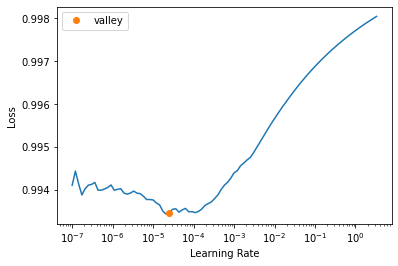

In [9]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(50, 5e-4)

epoch,train_loss,valid_loss,time
0,0.248178,0.253115,44:54
1,0.250437,0.254625,44:53
2,0.248723,0.251835,45:12
3,0.248900,0.253866,44:55
4,0.247123,0.244329,44:52
5,0.244221,0.246293,44:54
6,0.240939,0.239820,44:53
7,0.241679,0.249434,44:52
8,0.240875,0.246027,44:52
9,0.241449,0.245839,44:54


In [ ]:
torch.save(learn.model.state_dict(), 'checkpoints/dynamic_unet.pth')

In [ ]:
learn.export("checkpoints/unet50_learner.pkl")

In [ ]:
@patch
def new_empty(self: ClimateHackDataset):
    return self